# **Cara Lachenmayer and Carly Raskin**

# **COMP 4447 - DS Tools 1**

# **Final Project**

In [1]:
#import packages 
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from selenium.webdriver import Chrome
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
from selenium.webdriver.common.by import By
from sklearn.preprocessing import MinMaxScaler 
from matplotlib.pyplot import figure


import ssl
context = ssl._create_unverified_context()
#! pip install seaborn==0.11.2
#conda install numpy=1.21.5
#! pip install mlxtend

# Dataset, Motivation and Research Question 
## The question that we would like to answer is have our state and federal wages historically kept up with the cost of living? We will look at factors such as the median cost of rent and four household staple food items to answer this question.


## We're going to start by reading in our data and doing some EDA.


## We scraped our data from Government websites using Beautiful Soup and Selenium 

## The input for this project is the raw values on each date that they were available. The output is after cleaning and scaling is being able to compare each value together on the same scale.

## Scraping federal minimum wage data from 1938 - 2023. 
### Note that the DOL charts when the minimum wage has been changed. For the purposes of our project, we also need to have the current federal minimum wage. As the minimum wage has not changed since 2009, we had to manually add in the current minimum wage and date.

In [2]:
url = "https://www.dol.gov/agencies/whd/minimum-wage/history/chart"

response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

min_wage_table = soup.find('table')

# print(min_wage_table)

rows = min_wage_table.find_all("tr")

# print(rows)

headers = [cell.text.strip() for cell in rows[0].find_all("th")]
# print(headers)

dates = []
min_wage = []
for row in rows:
    cells = row.find_all("td")
    # print(cells)
    if len(cells) > 1:
      raw_dates = cells[0].find_all('p')[0].text.strip()
      date = re.search(r'[A-Z][a-z]{2} [0-9]{1,2}, [0-9]{4}', raw_dates) # for some reason some of the dates had extraneous information attached, so I only want the actual date format to be appended
      dates.append(date.group(0) if date else None)
    else:
        dates.append(None)
    if len(cells) > 1:
        wage_cell = cells[1].find_all('p')
        if len(wage_cell) > 0:
            dollar_amount = wage_cell[0].text.strip()
            min_wage.append(float(re.findall(r"\d+\.\d+", dollar_amount)[0]))
        else:
            min_wage.append(None)
    else:
        min_wage.append(None)

minWage_dat = {'Date': dates, 'Minimum Wage':min_wage}
wage_df = pd.DataFrame(minWage_dat)
# now add today's date and current min wage so we can graph it (the min wage is the same)
current_date = datetime.today().strftime('%b %d, %Y')
current_min_wage = 7.25  # current federal minimum wage as of Feb 17, 2023
wage_df.loc[len(wage_df)] = [current_date, current_min_wage]

wage_df['Date'] = pd.to_datetime(wage_df['Date'], format='%b %d, %Y')

wage_df


Date  Minimum Wage
0         NaT           NaN
1  1938-10-24          0.25
2  1939-10-24          0.30
3  1945-10-24          0.40
4  1950-01-25          0.75
5  1956-03-01          1.00
6  1961-09-03          1.15
7  1963-09-03          1.25
8  1964-09-03           NaN
9  1965-09-03           NaN
10 1967-02-01          1.40
11 1968-02-01          1.60
12 1969-02-01           NaN
13 1970-02-01           NaN
14 1971-02-01           NaN
15 1974-05-01          2.00
16        NaT          2.10
17 1976-01-01          2.30
18 1977-01-01           NaN
19 1978-01-01          2.65
20 1979-01-01          2.90
21 1980-01-01          3.10
22 1981-01-01          3.35
23 1990-04-01          3.80
24 1991-04-01          4.25
25 1996-10-01          4.75
26 1997-09-01          5.15
27 2007-07-24          5.85
28 2008-07-24          6.55
29 2009-07-24          7.25
30 2023-03-07          7.25

In [3]:
#checking for NA's 
wage_df.isna().sum()

Date            2
Minimum Wage    7
dtype: int64

In [4]:
#we want to back fill the Minimum Wage here becuase the null values are where the minimum wage has not changed, therefore it would be the same as the previous year
wage_df.bfill(inplace = True)


In [5]:
#checking for NA's again to make sure we've addressed it
wage_df.isna().sum()

Date            0
Minimum Wage    0
dtype: int64

In [6]:
#creating a new column named year 
wage_df['Year'] = pd.DatetimeIndex(wage_df['Date']).year

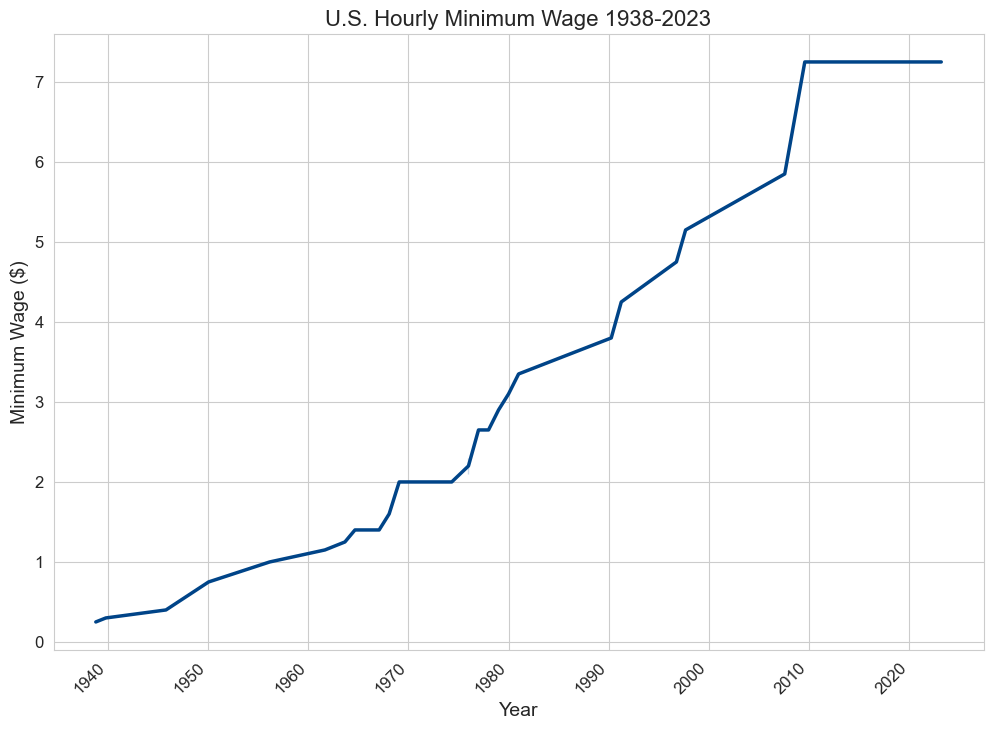

In [7]:
#graphing federal minimum wage over time 
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='Date', y='Minimum Wage', data=wage_df, linewidth=2.5, color='#004488')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Minimum Wage ($)', fontsize=14)
plt.title('U.S. Hourly Minimum Wage 1938-2023', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Scraping Colorado minimum wage from 1998 - 2023 from the Department of Labor and Employment. 

In [8]:
url = "https://cdle.colorado.gov/wage-and-hour-law/minimum-wage"
arr = requests.get(url)

soup = BeautifulSoup(arr.content, 'html.parser')
CoWageTable = soup.find('table')
rows = CoWageTable.find_all("tr")
headers = [cell.text.strip() for cell in rows[0].find_all("th")]

date = []
CoWage = []

for row in rows[1:]:
    cells = row.find_all("td")
    year = cells[0].text.strip()
    date.append(year)
    rent = cells[1].text.strip()
    CoWage.append(rent)

coWagedf = pd.DataFrame({'Date': date, "Minimum Wage": CoWage})
coWagedf['Date'] = pd.to_datetime(coWagedf['Date'])
coWagedf['Minimum Wage'] = coWagedf['Minimum Wage'].str.replace('$', '').astype(float)
coWagedf['Year'] = pd.to_datetime(coWagedf['Date']).dt.year.astype('Int64')
# we need to put the hourly wage as a multiplication of the hourly wage * 8 * 30 (8 hours/day 30 days in a month)
coWagedf['Monthly Wages'] = (coWagedf['Minimum Wage'] * 8) * 30
print(coWagedf)
print(coWagedf)

         Date  Minimum Wage  Year  Monthly Wages
0  2023-01-01         13.65  2023         3276.0
1  2022-01-01         12.56  2022         3014.4
2  2021-01-01         12.32  2021         2956.8
3  2020-01-01         12.00  2020         2880.0
4  2019-01-01         11.10  2019         2664.0
5  2018-01-01         10.20  2018         2448.0
6  2017-01-01          9.30  2017         2232.0
7  2016-01-01          8.31  2016         1994.4
8  2015-01-01          8.23  2015         1975.2
9  2014-01-01          8.00  2014         1920.0
10 2013-01-01          7.78  2013         1867.2
11 2012-01-01          7.64  2012         1833.6
12 2011-01-01          7.36  2011         1766.4
13 2010-01-01          7.24  2010         1737.6
14 2009-01-01          7.28  2009         1747.2
15 2008-01-01          7.02  2008         1684.8
16 2007-01-01          6.85  2007         1644.0
17 1998-08-08          5.15  1998         1236.0
         Date  Minimum Wage  Year  Monthly Wages
0  2023-01-01       

/var/folders/tb/9gjp2m8j0f5gzk9_b4xntb100000gn/T/ipykernel_87316/415553911.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  coWagedf['Minimum Wage'] = coWagedf['Minimum Wage'].str.replace('$', '').astype(float)


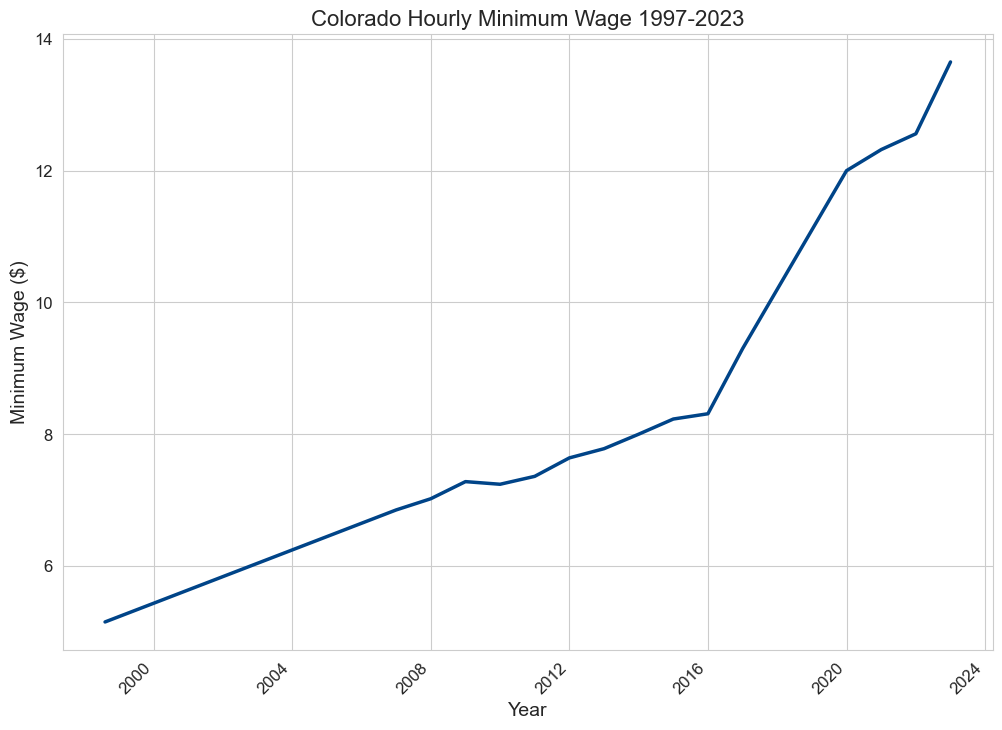

In [9]:
#graphing colorado minimum wage over time 
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='Date', y='Minimum Wage', data=coWagedf, linewidth=2.5, color='#004488')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Minimum Wage ($)', fontsize=14)
plt.title('Colorado Hourly Minimum Wage 1997-2023', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Scraping median rent prices in Colorado from a website that has aggregated data from the Department of Labor and the Bureau of Labor Statistics.

In [10]:
url = "https://ipropertymanagement.com/research/average-rent-by-year#colorado"
r = requests.get(url)

soup = BeautifulSoup(r.content, 'html.parser')
coloradoTable = soup.find('h3',id = 'colorado')
table = coloradoTable.findNext('table')
# print(table)

rows = table.find_all("tr")
headers = [cell.text.strip() for cell in rows[0].find_all("th")]
# print(headers)

years = []
rents = []

for row in rows[1:]:
    cells = row.find_all("td")
    # print(cells[1])
    year = cells[0].text.strip()
    years.append(year)
    rent = cells[1].text.strip()
    matchy = re.match(r'\$(\d+(,\d+)?)', rent)
    if matchy:
        rents.append(matchy.group())
    else:
        rents.append(None)


# print(rents)

CoRentdf = pd.DataFrame({'Year': years, 'Median Rent Price': rents})
# print(CoRentdf)
CoRentdf['Year'] = pd.to_datetime(CoRentdf['Year']).dt.year.astype('Int64')
CoRentdf['Median Rent Price'] = CoRentdf['Median Rent Price'].str.replace(',', '').str.replace('$', '').astype(float)
#CoRentdf['Median Rent Price'] = CoRentdf['Median Rent Price'].str[1:].astype(int)

print(CoRentdf)

   Year  Median Rent Price
0  1940               22.0
1  1950               39.0
2  1960               72.0
3  1970              110.0
4  1980              252.0
5  1990              418.0
6  2000              671.0
7  2020             1335.0
8  2021             1491.0
9  2022             1304.0


/var/folders/tb/9gjp2m8j0f5gzk9_b4xntb100000gn/T/ipykernel_87316/4107025861.py:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  CoRentdf['Median Rent Price'] = CoRentdf['Median Rent Price'].str.replace(',', '').str.replace('$', '').astype(float)


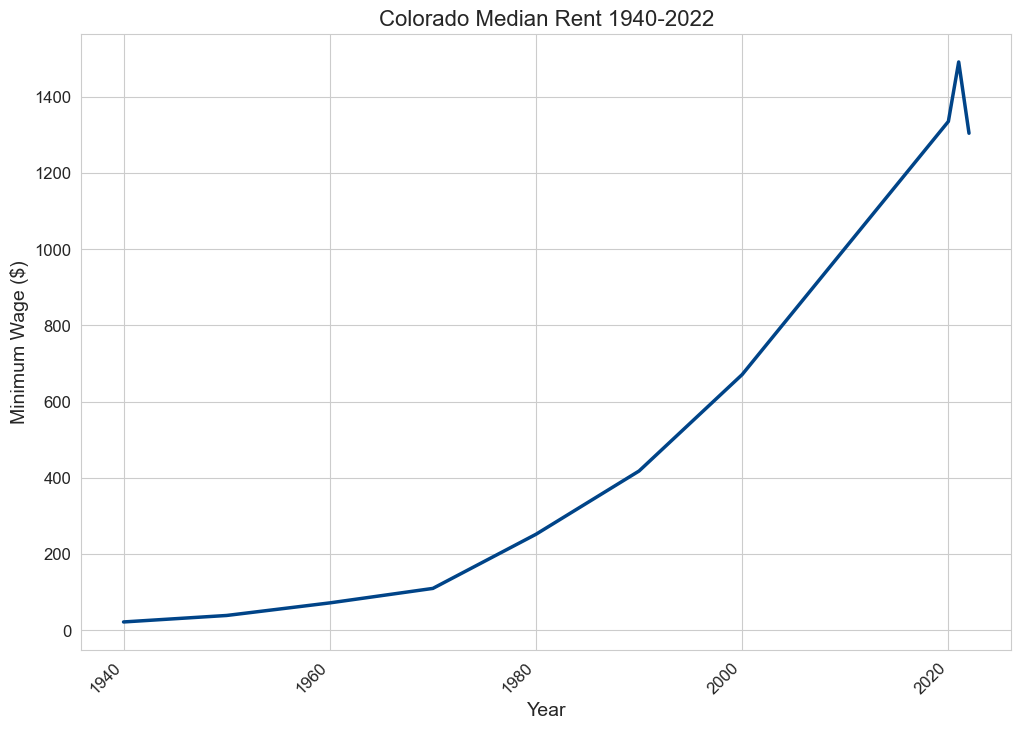

In [11]:
#graphing colorado minimum wage over time 
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='Year', y='Median Rent Price', data=CoRentdf, linewidth=2.5, color='#004488')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Minimum Wage ($)', fontsize=14)
plt.title('Colorado Median Rent 1940-2022', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Using Selenium to grab the price of bread from 1980-2023.

In [12]:
#use selenium to grab the csv 
driver = webdriver.Chrome('C:/Users/donda/anaconda3/bin/chromedriver')

# Grab the web page
driver.get('https://beta.bls.gov/dataViewer/view/timeseries/APU0000702111')

# now we want to change the dates we are looking at to the earliest available data
driver.find_element(By.XPATH, '//*[@id="dv-start-year"]').click()
driver.find_element(By.XPATH, '//*[@id="dv-start-year"]/option[1]').click()
downloadcsv = driver.find_element(By.ID,"csvclickAP").click()


time.sleep(5)
driver.close()


/var/folders/tb/9gjp2m8j0f5gzk9_b4xntb100000gn/T/ipykernel_87316/3879405647.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:/Users/donda/anaconda3/bin/chromedriver')


In [13]:
#read in csv and check that it looks okay
bread_price_df = pd.read_csv('/Users/caralachenmayer/Downloads/file.csv') #need to change path if you're running this on a different computer
bread_price_df['Label'] = pd.to_datetime(bread_price_df['Label'])
bread_price_df['Value'] = bread_price_df['Value'].astype(float)
print(bread_price_df.dtypes)
bread_price_df.head()

Series ID            object
Year                  int64
Period               object
Label        datetime64[ns]
Value               float64
dtype: object


Series ID  Year Period      Label  Value
0  APU0000702111  1980    M01 1980-01-01  0.501
1  APU0000702111  1980    M02 1980-02-01  0.507
2  APU0000702111  1980    M03 1980-03-01  0.502
3  APU0000702111  1980    M04 1980-04-01  0.507
4  APU0000702111  1980    M05 1980-05-01  0.504

In [14]:
#any null values? Nope
bread_price_df.isna().sum()

Series ID    0
Year         0
Period       0
Label        0
Value        0
dtype: int64

In [15]:
#finding mean price of bread for each year to graph
values = bread_price_df.groupby('Year').mean()
print(values)

         Value
Year          
1980  0.508750
1981  0.525167
1982  0.532167
1983  0.541583
1984  0.541250
1985  0.553250
1986  0.564667
1987  0.547417
1988  0.612833
1989  0.665583
1990  0.694583
1991  0.709833
1992  0.749833
1993  0.752083
1994  0.760667
1995  0.791250
1996  0.875667
1997  0.872250
1998  0.860167
1999  0.887083
2000  0.930167
2001  0.999083
2002  1.015583
2003  1.000750
2004  0.969417
2005  1.040333
2006  1.080500
2007  1.207333
2008  1.366417
2009  1.387417
2010  1.373333
2011  1.444667
2012  1.417667
2013  1.406667
2014  1.401250
2015  1.441000
2016  1.371250
2017  1.332583
2018  1.286000
2019  1.297667
2020  1.451667
2021  1.523583
2022  1.700250
2023  1.888000


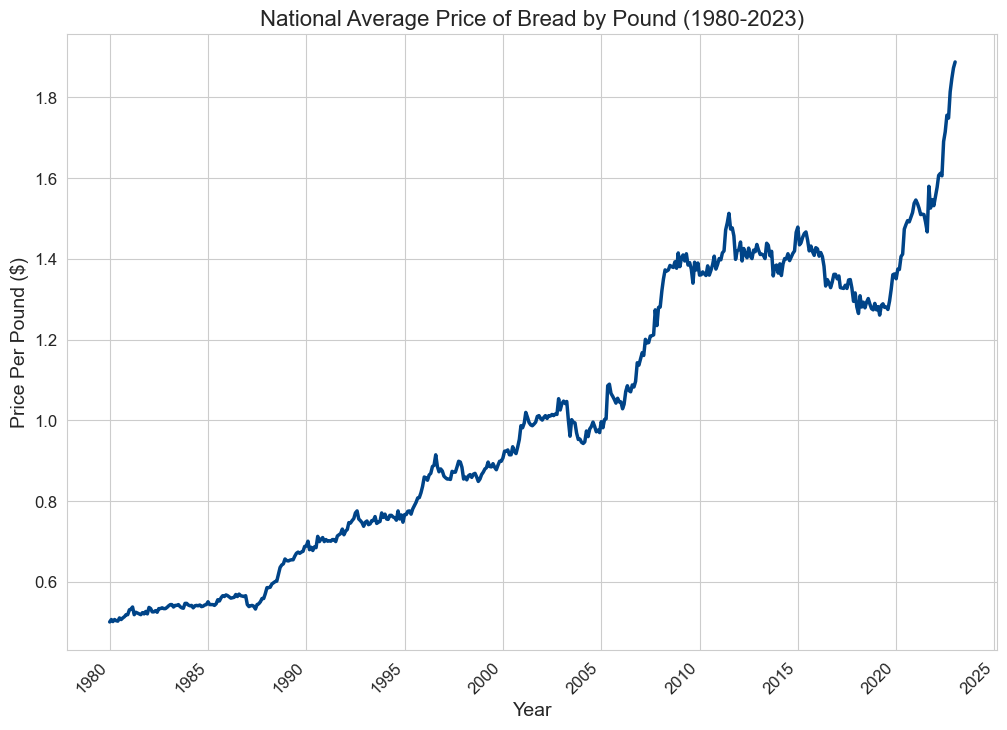

In [16]:
#graphing the national average price of bread over time 
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='Label', y='Value', data=bread_price_df, linewidth=2.5, color='#004488')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price Per Pound ($)', fontsize=14)
plt.title('National Average Price of Bread by Pound (1980-2023)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Bread prices were heavily affected by the war on Ukraine, since Russia and Ukraine account for 30% of the world wheat exports. 
### Sources: 
- https://www.cbsnews.com/news/ukraine-russia-war-bread-price-surge/
- https://www.reuters.com/world/europe/bread-consumers-swallow-cost-russia-ukraine-war-2022-03-04/

# Due to this, we are going to look at a few other household food items. 

## Using Selenium to grab the price of eggs per dozen from 1980-2023.

In [17]:
#use selenium to grab the csv 
driver = webdriver.Chrome('C:/Users/donda/anaconda3/bin/chromedriver')

# Grab the web page
driver.get('https://beta.bls.gov/dataViewer/view/timeseries/APU0000708111')

# now we want to change the dates we are looking at to the earliest available data
driver.find_element(By.XPATH, '//*[@id="dv-start-year"]').click()
driver.find_element(By.XPATH, '//*[@id="dv-start-year"]/option[1]').click()
downloadcsv = driver.find_element(By.ID,"csvclickAP").click()


time.sleep(5)
driver.close()


/var/folders/tb/9gjp2m8j0f5gzk9_b4xntb100000gn/T/ipykernel_87316/3501130194.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:/Users/donda/anaconda3/bin/chromedriver')


In [18]:
#read in egg csv and check that it looks okay
egg_price_df = pd.read_csv('/Users/caralachenmayer/Downloads/file (2).csv') #need to change path if you're running this on a different computer
egg_price_df['Label'] = pd.to_datetime(egg_price_df['Label'])
egg_price_df['Value'] = egg_price_df['Value'].astype(float)
print(egg_price_df.dtypes)
egg_price_df.head()

Series ID            object
Year                  int64
Period               object
Label        datetime64[ns]
Value               float64
dtype: object


Series ID  Year Period      Label  Value
0  APU0000708111  1980    M01 1980-01-01  0.879
1  APU0000708111  1980    M02 1980-02-01  0.774
2  APU0000708111  1980    M03 1980-03-01  0.812
3  APU0000708111  1980    M04 1980-04-01  0.797
4  APU0000708111  1980    M05 1980-05-01  0.737

In [19]:
#any null values? Nope 
egg_price_df.isna().sum()

Series ID    0
Year         0
Period       0
Label        0
Value        0
dtype: int64

In [20]:
#finding mean price of eggs for each year to graph
egg_values = egg_price_df.groupby('Year').mean()
print(egg_values)

         Value
Year          
1980  0.843833
1981  0.898667
1982  0.866833
1983  0.893667
1984  1.004667
1985  0.803583
1986  0.869583
1987  0.782583
1988  0.789500
1989  0.997833
1990  1.013917
1991  0.989250
1992  0.860167
1993  0.911417
1994  0.862833
1995  0.924500
1996  1.106333
1997  1.058333
1998  1.037417
1999  0.959250
2000  0.913500
2001  0.929333
2002  1.032000
2003  1.244417
2004  1.339500
2005  1.218167
2006  1.306250
2007  1.676250
2008  1.986500
2009  1.664000
2010  1.659667
2011  1.769500
2012  1.837667
2013  1.909500
2014  2.018500
2015  2.469417
2016  1.684167
2017  1.467083
2018  1.741667
2019  1.395833
2020  1.505750
2021  1.674000
2022  2.856833
2023  4.823000


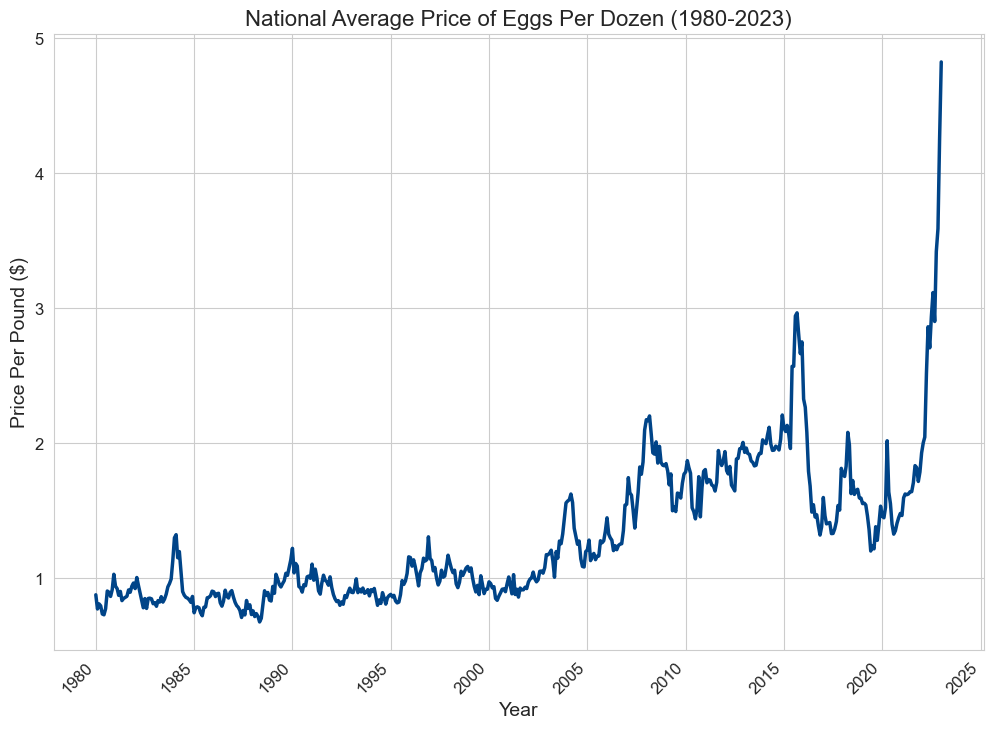

In [21]:
#graphing the national average price of eggs over time 
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='Label', y='Value', data=egg_price_df, linewidth=2.5, color='#004488')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price Per Pound ($)', fontsize=14)
plt.title('National Average Price of Eggs Per Dozen (1980-2023)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# It's also important to note that egg prices sky rocketed in 2022, increasing by 70% according to the latest data from the Bureau of Labor Statistics. This was due to an avian flu outbreak which wiped out 50.54 million birds in the U.S. in 2022. SO... let's look at another common household food item over the years. 

## Sources: 
- https://www.ams.usda.gov/sites/default/files/media/Egg%20Markets%20Overview.pdf
- https://www.cnbc.com/2023/02/14/heres-the-breakdown-of-the-inflation-report-for-january-in-one-chart.html

## Using Selenium to grab the price of milk from 1980-2023.

In [22]:
#use selenium to grab the csv 
driver = webdriver.Chrome('C:/Users/donda/anaconda3/bin/chromedriver')

# Grab the web page
driver.get('https://beta.bls.gov/dataViewer/view/timeseries/APU0000709112')

# now we want to change the dates we are looking at to the earliest available data
driver.find_element(By.XPATH, '//*[@id="dv-start-year"]').click()
driver.find_element(By.XPATH, '//*[@id="dv-start-year"]/option[1]').click()
downloadcsv = driver.find_element(By.ID,"csvclickAP").click()


time.sleep(5)
driver.close()

/var/folders/tb/9gjp2m8j0f5gzk9_b4xntb100000gn/T/ipykernel_87316/3465318700.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:/Users/donda/anaconda3/bin/chromedriver')


In [23]:
#read in milk csv and check that it looks okay
milk_price_df = pd.read_csv('/Users/caralachenmayer/Downloads/file (3).csv') #need to change path if you're running this on a different computer
milk_price_df['Label'] = pd.to_datetime(milk_price_df['Label'])
milk_price_df['Value'] = milk_price_df['Value'].astype(float)
print(milk_price_df.dtypes)
milk_price_df.head()

Series ID            object
Year                  int64
Period               object
Label        datetime64[ns]
Value               float64
dtype: object


Series ID  Year Period      Label  Value
0  APU0000709112  1995    M07 1995-07-01  2.477
1  APU0000709112  1995    M08 1995-08-01  2.482
2  APU0000709112  1995    M09 1995-09-01  2.459
3  APU0000709112  1995    M10 1995-10-01  2.473
4  APU0000709112  1995    M11 1995-11-01  2.493

In [24]:
#any null values? Nope 
milk_price_df.isna().sum()

Series ID    0
Year         0
Period       0
Label        0
Value        0
dtype: int64

In [25]:
#finding mean price of milk for each year to graph
milk_values = milk_price_df.groupby('Year').mean()
print(milk_values)

         Value
Year          
1995  2.483667
1996  2.623167
1997  2.614000
1998  2.703750
1999  2.842750
2000  2.780667
2001  2.884250
2002  2.757250
2003  2.761083
2004  3.155917
2005  3.186833
2006  3.081333
2007  3.503250
2008  3.795333
2009  3.109000
2010  3.258500
2011  3.571583
2012  3.492500
2013  3.461917
2014  3.693667
2015  3.418750
2016  3.204250
2017  3.225500
2018  2.895833
2019  3.035667
2020  3.318417
2021  3.544500
2022  4.091000
2023  4.204000


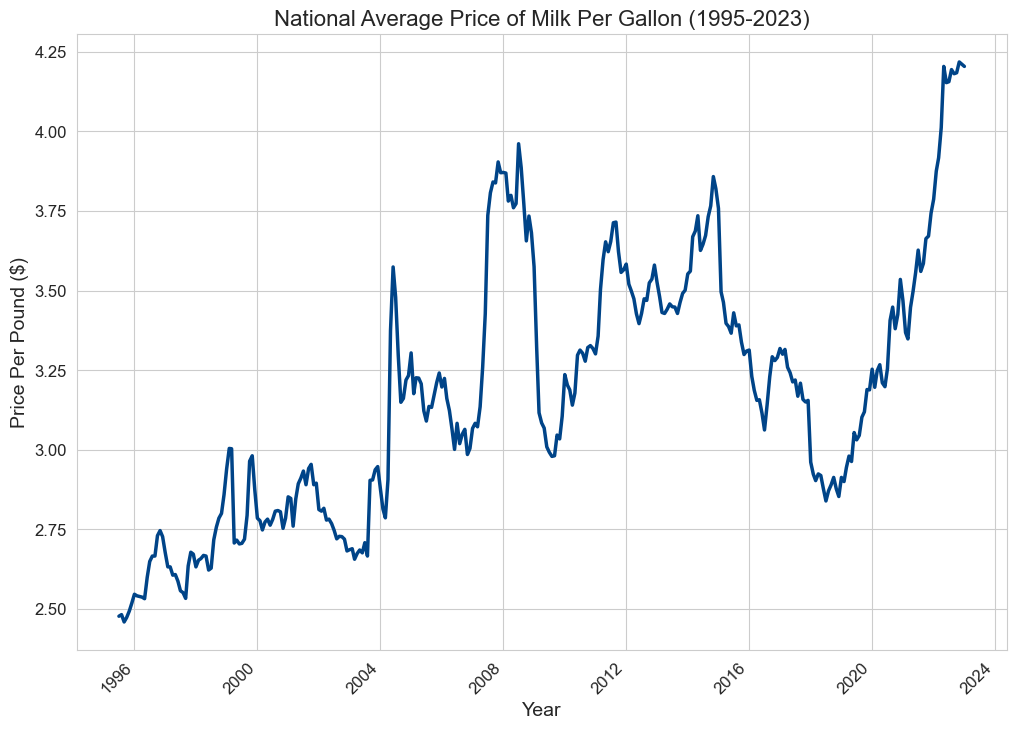

In [26]:
#graphing the national average price of milk over time 
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='Label', y='Value', data=milk_price_df, linewidth=2.5, color='#004488')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price Per Pound ($)', fontsize=14)
plt.title('National Average Price of Milk Per Gallon (1995-2023)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Which came first, the chicken or the egg? Just kidding, but let's look at the price of chicken over the years since generally households buy a protein on a regular basis. 

## Using Selenium to grab the price of chicken from 1980-2023.

In [27]:
#use selenium to grab the chicken csv 
driver = webdriver.Chrome('C:/Users/donda/anaconda3/bin/chromedriver')

# Grab the web page
driver.get('https://beta.bls.gov/dataViewer/view/timeseries/APU0000706111')

# now we want to change the dates we are looking at to the earliest available data
driver.find_element(By.XPATH, '//*[@id="dv-start-year"]').click()
driver.find_element(By.XPATH, '//*[@id="dv-start-year"]/option[1]').click()
downloadcsv = driver.find_element(By.ID,"csvclickAP").click()


time.sleep(5)
driver.close()

/var/folders/tb/9gjp2m8j0f5gzk9_b4xntb100000gn/T/ipykernel_87316/4087209597.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:/Users/donda/anaconda3/bin/chromedriver')


In [28]:
#read in chicken csv and check that it looks okay
chicken_price_df = pd.read_csv('/Users/caralachenmayer/Downloads/file (4).csv') #need to change path if you're running this on a different computer
chicken_price_df['Label'] = pd.to_datetime(chicken_price_df['Label'])
chicken_price_df['Value'] = chicken_price_df['Value'].astype(float)
print(chicken_price_df.dtypes)
chicken_price_df.head()

Series ID            object
Year                  int64
Period               object
Label        datetime64[ns]
Value               float64
dtype: object


Series ID  Year Period      Label  Value
0  APU0000706111  1980    M01 1980-01-01  0.699
1  APU0000706111  1980    M02 1980-02-01  0.673
2  APU0000706111  1980    M03 1980-03-01  0.655
3  APU0000706111  1980    M04 1980-04-01  0.638
4  APU0000706111  1980    M05 1980-05-01  0.628

In [29]:
#any null values? Yes!
chicken_price_df.isna().sum()

Series ID    0
Year         0
Period       0
Label        0
Value        0
dtype: int64

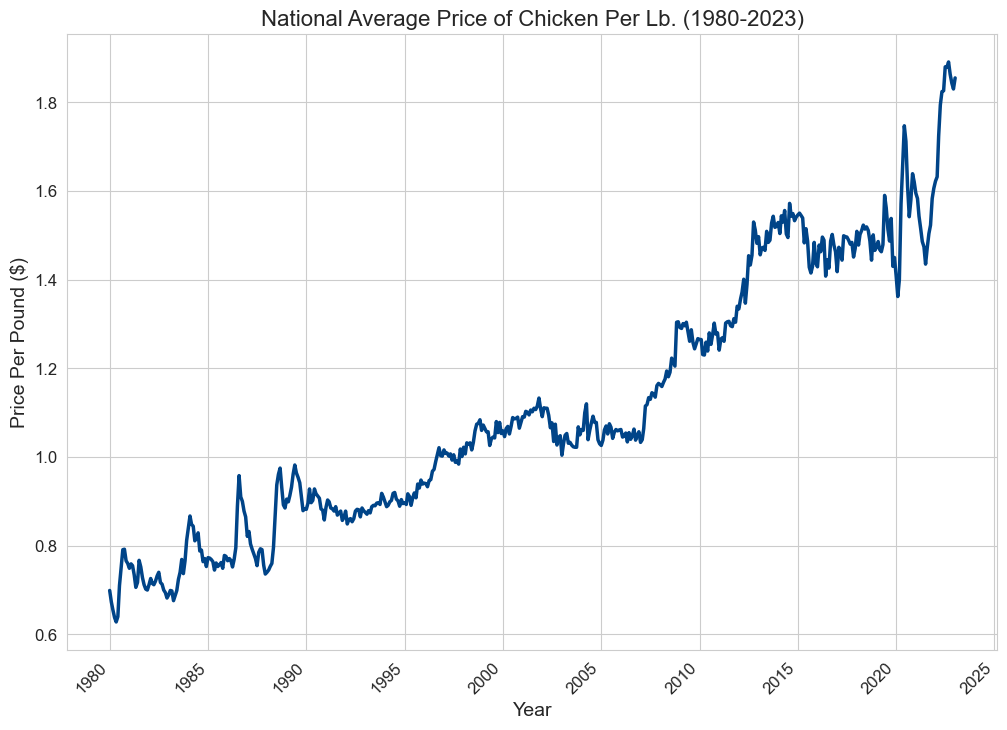

In [30]:
#graphing the national average price of chicken over time 
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='Label', y='Value', data=chicken_price_df, linewidth=2.5, color='#004488')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price Per Pound ($)', fontsize=14)
plt.title('National Average Price of Chicken Per Lb. (1980-2023)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Data Analysis

### There has been a lot of discussions online comparing the cost of living and how those making minimum wage can not afford a place anywhere in the United States, hence the discussions of raising minimum and Colorado doing so in 2016. However, we did not find any other analysis that was similar to ours in terms of combining values on different scales and scaling household staples to compare them on a more realistic set of guidlines. 

## Scaling our different datsets between 0-1 will be beneficial here to see truly how far apart the data points are on the same scale. We are going to add a new column to each dataframe for the scaled points.

In [31]:
# mix-max scale the data between 0 and 1
scaler = MinMaxScaler() 

#let's add new columns to the df's with scaled data
#federal min wage 
min_wage = wage_df['Minimum Wage'].values.reshape(-1,1)
wage_df['Scaled Data'] = scaler.fit_transform(min_wage)
#wage_df

#co min wage 
co_min_wage = coWagedf['Minimum Wage'].values.reshape(-1,1)
coWagedf['Scaled Data'] = scaler.fit_transform(co_min_wage)
#coWagedf

#co rent 
co_rent = CoRentdf['Median Rent Price'].values.reshape(-1,1)
CoRentdf['Scaled Data'] = scaler.fit_transform(co_rent)
#CoRentdf

#bread prices
bread = bread_price_df['Value'].values.reshape(-1,1)
bread_price_df['Scaled Data'] = scaler.fit_transform(bread)
#bread_price_df

#egg prices
eggs = egg_price_df['Value'].values.reshape(-1,1) 
egg_price_df['Scaled Data'] = scaler.fit_transform(eggs)
#egg_price_df

#milk prices 
milk = milk_price_df['Value'].values.reshape(-1,1)
milk_price_df['Scaled Data'] = scaler.fit_transform(milk)
#milk_price_df

#chicken prices 
chicken = chicken_price_df['Value'].values.reshape(-1,1)
chicken_price_df['Scaled Data'] = scaler.fit_transform(chicken)
#chicken_price_df



In [32]:
# let's look at some summary statistics for our new scaled value columns 
# first for wages 
print("Summary Statistics for Federal Min. Wage and Scaled Values:\n",wage_df[['Minimum Wage', 'Scaled Data']].describe())
print("\nSummary Statistics for Colorado's Min. Wage and Scaled Values:\n",coWagedf[['Minimum Wage', 'Scaled Data']].describe())

#next, for rent
print("\nSummary Statistics for Colorado Median Rent and Scaled Values:\n",CoRentdf[['Median Rent Price', 'Scaled Data']].describe())

#finally for the household staples
print("\nSummary Statistics for Bread's Price and Scaled Values:\n",bread_price_df[['Value', 'Scaled Data']].describe())
print("\nSummary Statistics for Milk's Price and Scaled Values:\n",milk_price_df[['Value', 'Scaled Data']].describe())
print("\nSummary Statistics for Eggs's Price and Scaled Values:\n",egg_price_df[['Value', 'Scaled Data']].describe())
print("\nSummary Statistics for Chicken's Price and Scaled Values:\n",chicken_price_df[['Value', 'Scaled Data']].describe())


Summary Statistics for Federal Min. Wage and Scaled Values:
        Minimum Wage  Scaled Data
count     31.000000    31.000000
mean       2.679032     0.347005
std        2.029728     0.289961
min        0.250000     0.000000
25%        1.325000     0.153571
50%        2.000000     0.250000
75%        3.575000     0.475000
max        7.250000     1.000000

Summary Statistics for Colorado's Min. Wage and Scaled Values:
        Minimum Wage  Scaled Data
count     18.000000    18.000000
mean       8.999444     0.452876
std        2.398241     0.282146
min        5.150000     0.000000
25%        7.300000     0.252941
50%        8.115000     0.348824
75%       10.875000     0.673529
max       13.650000     1.000000

Summary Statistics for Colorado Median Rent and Scaled Values:
        Median Rent Price  Scaled Data
count           10.00000    10.000000
mean           571.40000     0.373996
std            591.46714     0.402632
min             22.00000     0.000000
25%             81.50000 

# Now that our data is on the same scale, let's first compare minimum wage in Colorado vs. Colorado Rent. 

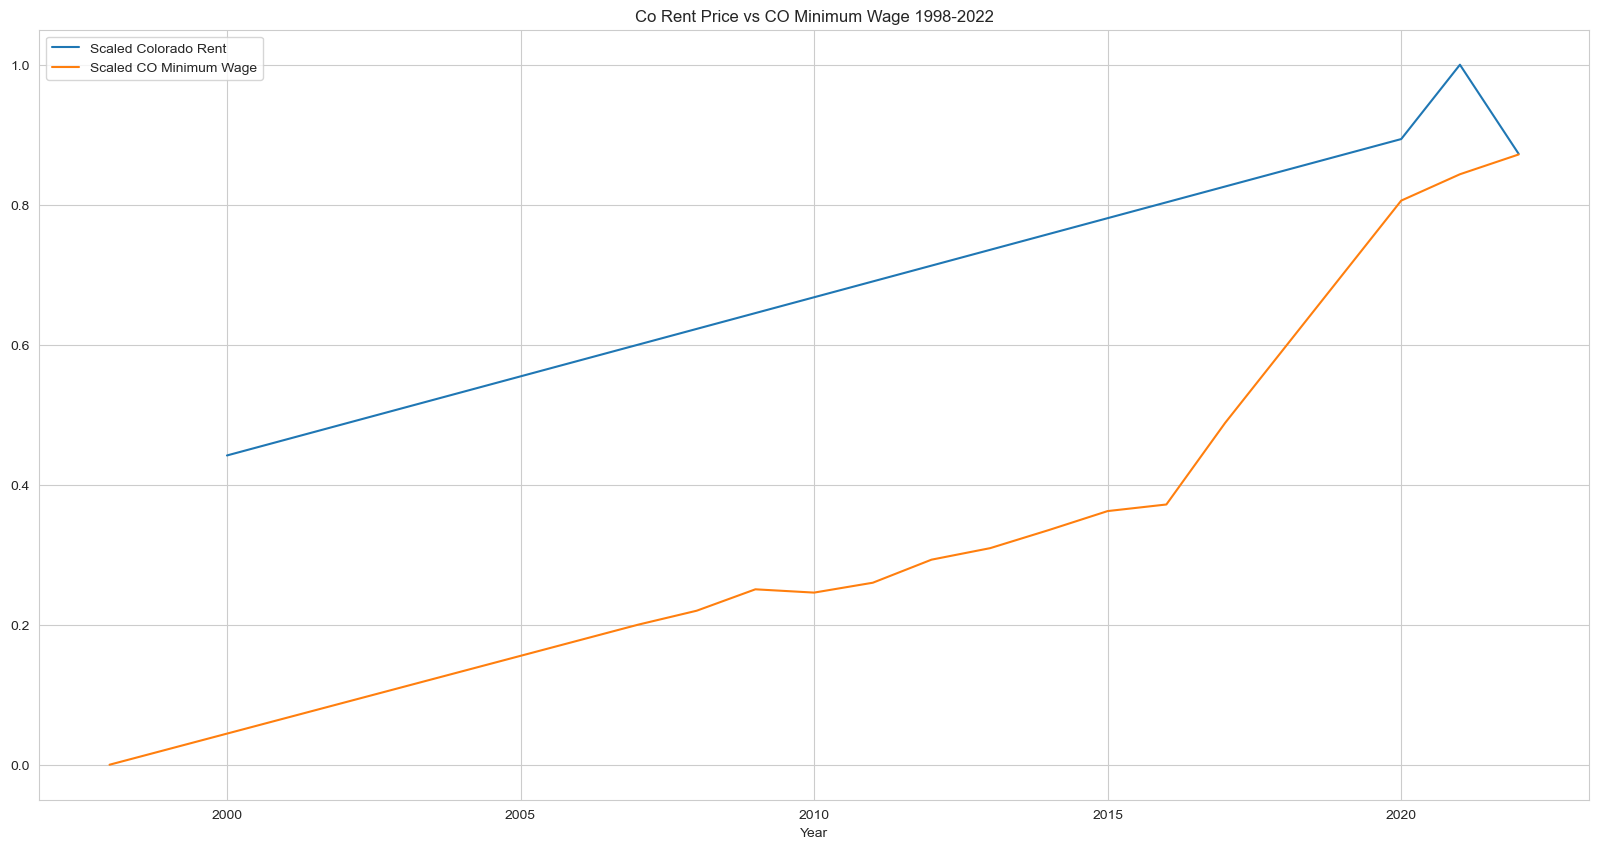

In [33]:
#Colorado minimum wage and median rent price 1998-2022 since this is the earliest we have data for minimum wage
CoRentdf = CoRentdf[CoRentdf['Year'] >= 1998]
coWagedf = coWagedf[coWagedf['Year'] <= 2022]

figure(figsize=(20, 10), dpi=100)
plt.plot(CoRentdf['Year'],CoRentdf['Scaled Data'], label = 'Scaled Colorado Rent')
plt.plot(coWagedf['Year'], coWagedf['Scaled Data'], label = 'Scaled CO Minimum Wage')
plt.xlabel('Year')
plt.title('Co Rent Price vs CO Minimum Wage 1998-2022')
plt.legend()
plt.show()


## This graph shows us that it was not until recently that someone making Colorado minimum wage could afford the price of rent. We can see a big jump in 2017 when the minimum wage jumped 12% to help make this possible.

# Next, let's first compare Federal minimum wage vs. Colorado minimum wage.

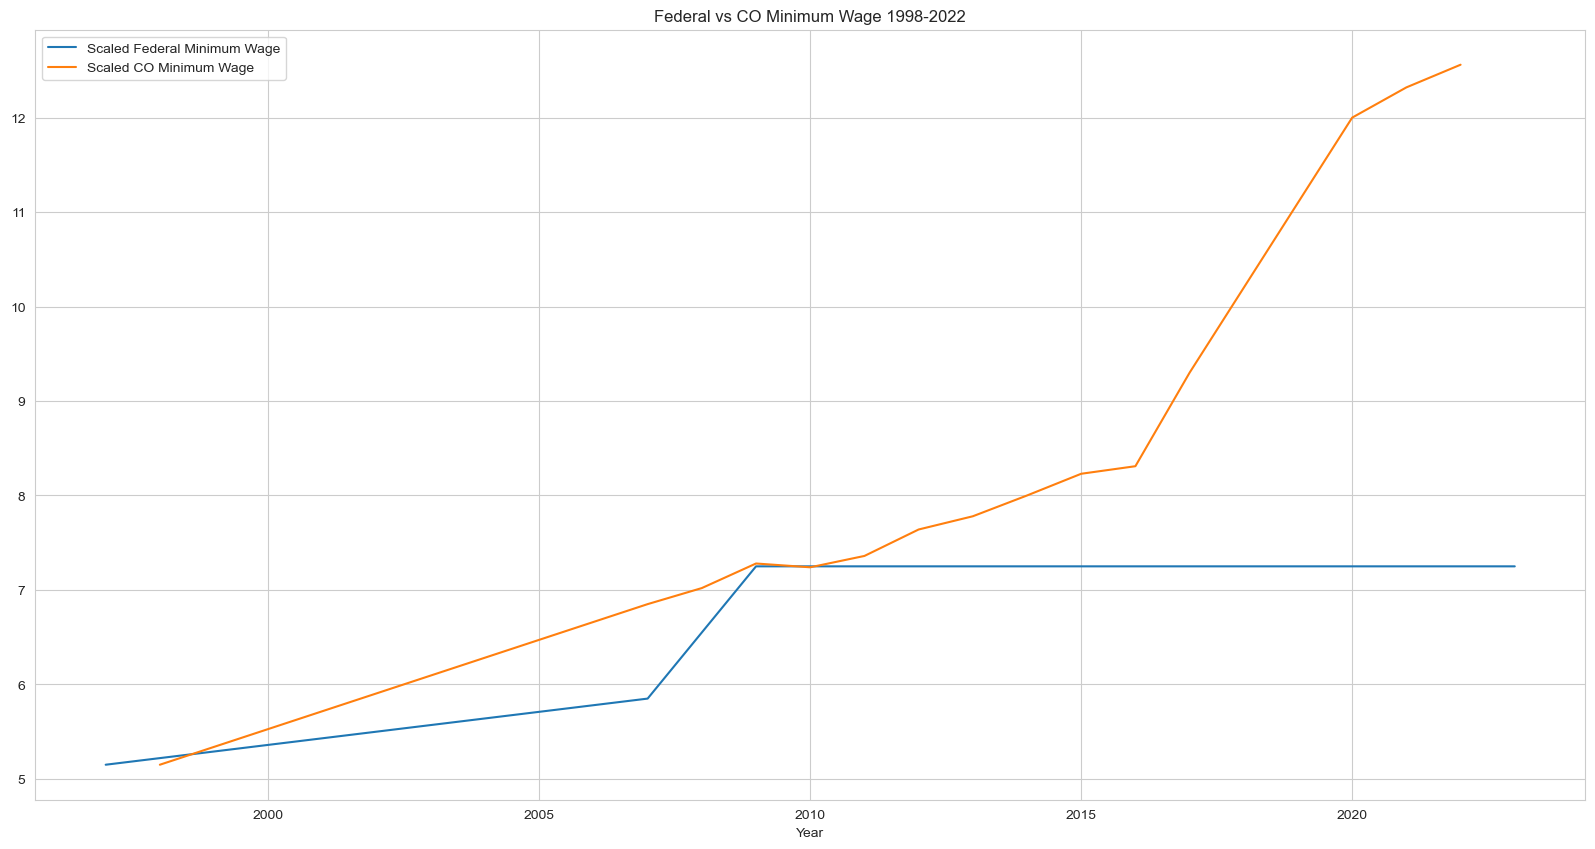

In [34]:
# Let's look at Federal Vs. Colorado Minimum Wage 
wage_df = wage_df[wage_df['Year'] >= 1997]

figure(figsize=(20, 10), dpi=100)
plt.plot(wage_df['Year'], wage_df['Minimum Wage'], label = 'Scaled Federal Minimum Wage')
plt.plot(coWagedf['Year'], coWagedf['Minimum Wage'], label = 'Scaled CO Minimum Wage')
plt.xlabel('Year')
plt.title('Federal vs CO Minimum Wage 1998-2022')
plt.legend()
plt.show()


# Even though rent was increasing much more than Colorado minimum wage, those making Colorado minimum wage were much better off than those making the Federal minimum wage which has not increased since 2009. (!!!) 

# Next, let's look at the cost of household staple foods, bread, eggs, milk and chicken from 1995 - 2022, because 1995 is the latest we have data for milk and chicken. 

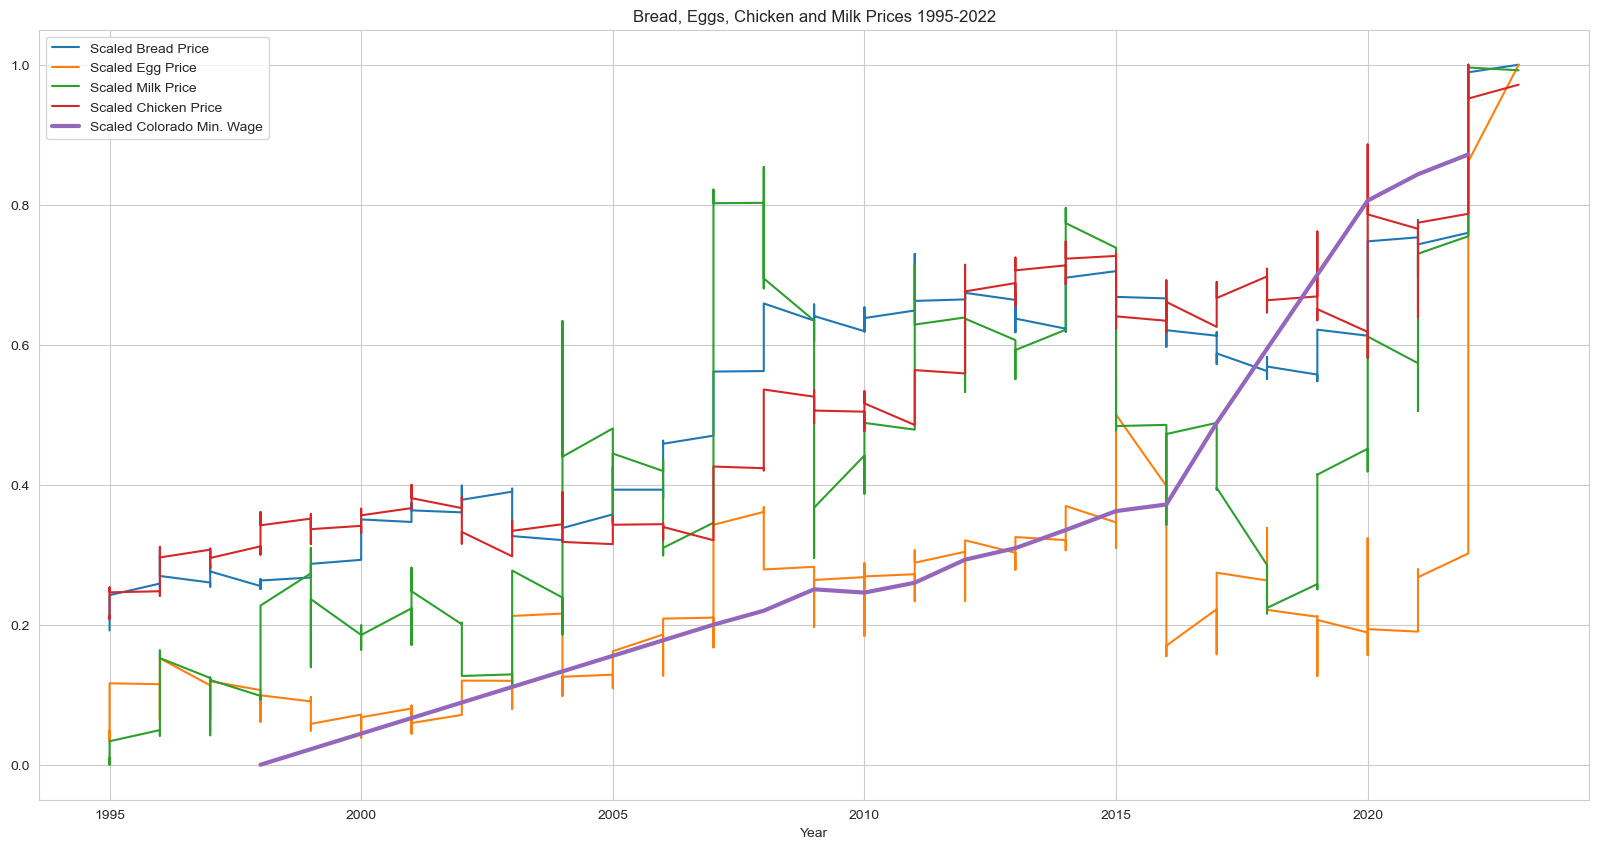

In [38]:
#bread, egg and chicken data goes further back so we need to put a date filter on it
bread_price_df = bread_price_df[bread_price_df['Year'] >= 1995]
egg_price_df = egg_price_df[egg_price_df['Year'] >= 1995]
chicken_price_df = chicken_price_df[chicken_price_df['Year'] >= 1995]

figure(figsize=(20, 10), dpi=100)
plt.plot(bread_price_df['Year'],bread_price_df['Scaled Data'], label = 'Scaled Bread Price')
plt.plot(egg_price_df['Year'], egg_price_df['Scaled Data'], label = 'Scaled Egg Price')
plt.plot(milk_price_df['Year'], milk_price_df['Scaled Data'], label = 'Scaled Milk Price')
plt.plot(chicken_price_df['Year'],chicken_price_df['Scaled Data'], label = 'Scaled Chicken Price')
plt.plot(coWagedf['Year'], coWagedf['Scaled Data'], label = "Scaled Colorado Min. Wage",  linewidth=3)
plt.xlabel('Year')
plt.title('Bread, Eggs, Chicken and Milk Prices 1995-2022')
plt.legend()
plt.show()


# While this graph is pretty busy, it shows us that the price of household items vary quite a bit, which we can generally attribute to things such as the wheat shortage or avian flu, but in general while on the same scale as rent, they cost quite a bit more. 

# Lastly, we will use the data before it's scaled to chart the differences between wages and bread to see if wages have kept up with the price of bread.

In [36]:
# to do this we have to merge the dataframes
merged_df = pd.merge(bread_price_df, wage_df, on='Year')

# now we want to get the difference in wage and bread price
merged_df['Difference'] = merged_df['Minimum Wage'] -merged_df['Value']
print(merged_df.head())

       Series ID  Year Period      Label  Value  Scaled Data_x       Date  \
0  APU0000702111  1997    M01 1997-01-01  0.862       0.260274 1997-09-01   
1  APU0000702111  1997    M02 1997-02-01  0.858       0.257390 1997-09-01   
2  APU0000702111  1997    M03 1997-03-01  0.855       0.255227 1997-09-01   
3  APU0000702111  1997    M04 1997-04-01  0.855       0.255227 1997-09-01   
4  APU0000702111  1997    M05 1997-05-01  0.854       0.254506 1997-09-01   

   Minimum Wage  Scaled Data_y  Difference  
0          5.15            0.7       4.288  
1          5.15            0.7       4.292  
2          5.15            0.7       4.295  
3          5.15            0.7       4.295  
4          5.15            0.7       4.296  


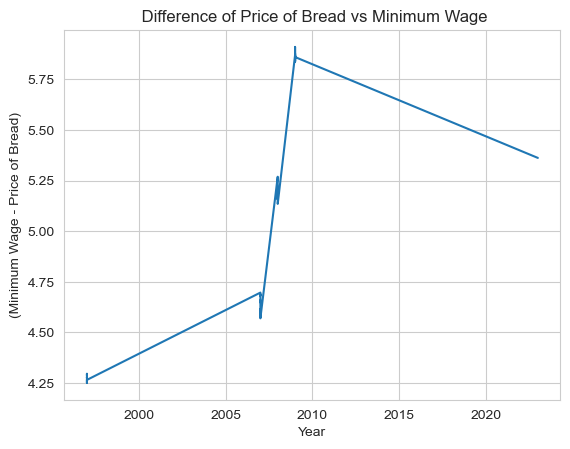

In [37]:
#plot the difference between the two 
plt.plot(merged_df['Year'], merged_df['Difference'])
plt.xlabel('Year')
plt.ylabel('(Minimum Wage - Price of Bread)')
plt.title(' Difference of Price of Bread vs Minimum Wage')
plt.show()

# This last visual shows us that while the cost of a basic household staple continues to rise, wages are not following the same general trend. This is made clear by the difference getting larger and larger over time, with a massive jump right around 2008. 